## データの読み込み

In [1]:
import pandas as pd
DATA_DIR = 'tracon01/'
train  = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
repo = pd.read_csv(DATA_DIR + 'repo.csv')
commits = pd.read_csv(DATA_DIR + "commits_sampled_10.csv")
issues = pd.read_csv(DATA_DIR + "issues.csv")

train.describe()
test.describe()
train['active'].value_counts()

active
False    2698
True      985
Name: count, dtype: int64

## データの処理と選定

In [2]:
from datetime import datetime as dt

train["repo_url"] = train["owner"] + "/" + train["repo"]
test["repo_url"] = test["owner"] + "/" + test["repo"]

# あんまり役に立ってなさそうだったのでコメントアウト
# train["star_file_ratio"] = train["n_files"] / train["n_stars"]
# test["star_file_ratio"] = test["n_files"] / test["n_stars"]

### コミット情報のデータフレーム作成

In [3]:
repo_commit_count = {} # リポジトリの名前 → コミットの数
repo_latest_commit_date = {} # リポジトリの名前 → 最新コミット日時
repo_commit_members = {} # リポジトリの名前 →（コミットしたメンバー → コミット数）

for row in commits.itertuples():
    date = dt.strptime(row.author_date, "%Y-%m-%d %H:%M:%S").timestamp()
    for repo_name in eval(row.repo_names): # コミットに対象のリポジトリが複数あるってどういうことだ？
        repo_commit_count[repo_name] = repo_commit_count.get(repo_name, 0) + 1 # 1追加
        repo_latest_commit_date[repo_name] = max(repo_latest_commit_date.get(repo_name, 0), date)
        if repo_name not in repo_commit_members:
            repo_commit_members[repo_name] = {}
        repo_commit_members[repo_name][row.author_name] = repo_commit_members[repo_name].get(row.author_name, 0) + 1

# データフレームへの変換
repo_commit_count_df = pd.DataFrame(
    {"repo_url": repo_commit_count.keys(), "n_commits": repo_commit_count.values()}
)
repo_latest_commit_date_df = pd.DataFrame(
    {"repo_url": repo_latest_commit_date.keys(), "last_commit_date": repo_latest_commit_date.values()}
)
repo_commit_members_df = pd.DataFrame(
    {"repo_url": repo_commit_members.keys(), "n_commit_members": [len(e) for e in repo_commit_members.values()]}
)

### イシュー情報のデータフレーム作成

In [4]:
pull_count_map = {}
issue_count_map = {}
issue_open_count_map = {}

for row in issues.itertuples():
    pull_count_map[row.repo_id] = pull_count_map.get(row.repo_id, 0) + 1
    issue_count_map[row.repo_id] = issue_count_map.get(row.repo_id, 0) + 1
    if row.state == "open":
        issue_open_count_map[row.repo_id] = issue_open_count_map.get(row.repo_id, 0) + 1

pull_count_df = pd.DataFrame(
    {"repo_id": pull_count_map.keys(), "n_pulls": pull_count_map.values()}
)
issue_count_df = pd.DataFrame(
    {"repo_id": issue_count_map.keys(), "n_issues": issue_count_map.values()}
)
issue_open_count_df = pd.DataFrame(
    {"repo_id": issue_open_count_map.keys(), "n_open_issues": issue_open_count_map.values()}
)

### マージと選定

In [5]:
train = train.merge(repo, on='repo_id', how='left')
test = test.merge(repo, on='repo_id', how='left')

train["n_stars"] = train["stars"].apply(lambda s: s.count(','))
test["n_stars"] = test["stars"].apply(lambda s: s.count(','))

train["n_files"] = train["files"].apply(lambda s: s.count(','))
test["n_files"] = test["files"].apply(lambda s: s.count(','))

train = train.merge(repo_commit_count_df, on="repo_url", how="left")
test = test.merge(repo_commit_count_df, on="repo_url", how="left")

train = train.merge(repo_latest_commit_date_df, on="repo_url", how="left")
test = test.merge(repo_latest_commit_date_df, on="repo_url", how="left")

train = train.merge(repo_commit_members_df, on="repo_url", how="left")
test = test.merge(repo_commit_members_df, on="repo_url", how="left")

train = train.merge(pull_count_df, on="repo_id", how="left")
test = test.merge(pull_count_df, on="repo_id", how="left")

train = train.merge(issue_count_df, on="repo_id", how="left")
test = test.merge(issue_count_df, on="repo_id", how="left")

train = train.merge(issue_open_count_df, on="repo_id", how="left")
test = test.merge(issue_open_count_df, on="repo_id", how="left")


def show_dist(df, key, log):
    sns.displot(df[key], kde=False, rug=False, bins=500, log_scale=10 if log else None).set(title=f"{key} log : all")
    sns.displot(df[df["active"]][key], kde=False, rug=False, bins=500, log_scale=10 if log else None).set(
        title=f"{key} log : true"
    )
    sns.displot(df[df["active"]][key], kde=False, rug=False, bins=500, log_scale=10 if log else None).set(
        title=f"{key} log : false"
    )

use_cols = ["n_stars", "n_files", "n_commits", "n_issues", "n_pulls", "last_commit_date", "n_commit_members"]
target_col = "active"

## 学習

In [6]:
import numpy as np
from sklearn.model_selection import KFold # 交差検証用ライブラリ
import lightgbm as lgb # 勾配ブースティング木で学習してくれるやつ

def train_fold(train_X: pd.DataFrame, train_y: pd.Series, valid_X: pd.DataFrame, valid_y: pd.Series) -> lgb.Booster:
    # GBDT の学習のためにデータを変換したうえで、学習を実行する関数
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_valid = lgb.Dataset(valid_X, valid_y, reference=lgb_train)
    params = {
        'objective': 'binary',
        'metric': ['auc', 'accuracy'],
    }
    model = lgb.train(params, lgb_train, valid_sets=[lgb_valid], callbacks=[lgb.early_stopping(100, first_metric_only=True)])
    return model

models = []
kf = KFold(n_splits=4, shuffle=True, random_state=20) # 4分割交差検証

for train_index, valid_index in kf.split(train): # kf.split(train) は長さ 4 の配列
    # 各 train_index と valid_index は、それぞれ全データの中から訓練用・テスト用に分けられた index の配列
    train_data = train.iloc[train_index]
    valid_data = train.iloc[valid_index]

    train_X = train_data[use_cols]
    train_y = train_data[target_col] # それぞれ学習に使うフィールド、予測したいフィールド
    valid_X = valid_data[use_cols]
    valid_y = valid_data[target_col]

    model = train_fold(train_X, train_y, valid_X, valid_y)
    models.append(model) # 長さ 4 の配列 models ができる

[LightGBM] [Info] Number of positive: 735, number of negative: 2027
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 2762, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266112 -> initscore=-1.014442
[LightGBM] [Info] Start training from score -1.014442
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.930131
Evaluated only: auc
[LightGBM] [Info] Number of positive: 730, number of negative: 2032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number 

## Valid の予測

In [7]:
oof_pred = np.zeros(len(train)) # 単に train と同じ長さの 0 で初期化された配列を作る
for i, (train_index, valid_index) in enumerate(kf.split(train)):
    valid_data = train.iloc[valid_index]
    valid_X = valid_data[use_cols] # バリデーションに使うデータの中で、予測の材料となるフィールドの行
    oof_pred[valid_index] = models[i].predict(valid_X)
    # この瞬間に oof_pred は valid_index だけに予測結果が入る

# 4回異なる valid_index で実行することで、ちょうどぴったり oof_pred の全ての要素が埋まる

## 用語の補足

- TPR は「正しく(True) ポジティブと判定された（Positive）割合 (Rate)」
- FPR は「誤って(False)ポジティブと判定された（Positive）割合 (Rate)」
- TNR は 1 - FPR、FNR は 1 - TPR で求められる。これで表が埋まる

今回の Positive は「リポジトリがアクティブである」という命題かな\
モデルは Positive か Negative かを予測するが、本来の予測結果は確率なので 0 ~ 1 の実数値をとる\
0.5 以上で「モデルは Positive と判定した」ことにできるし、0.3 以上とすることもできる\
この閾値をいろいろ変えたとき、TPR と FPR がどう変動するかを変えたときのグラフが ROC 曲線

また、ROC 曲線の下側の面積が AUC。つまり、ある閾値における一致率 Accuracy よりも一般的にモデルの評価ができる\
ROC 曲線が一番張り出して（0, 0）→ (0, 1) → (1, 1) という折れ線であるときこのモデルは完璧、ということになる

## 予測精度の可視化

0.9178611342110908


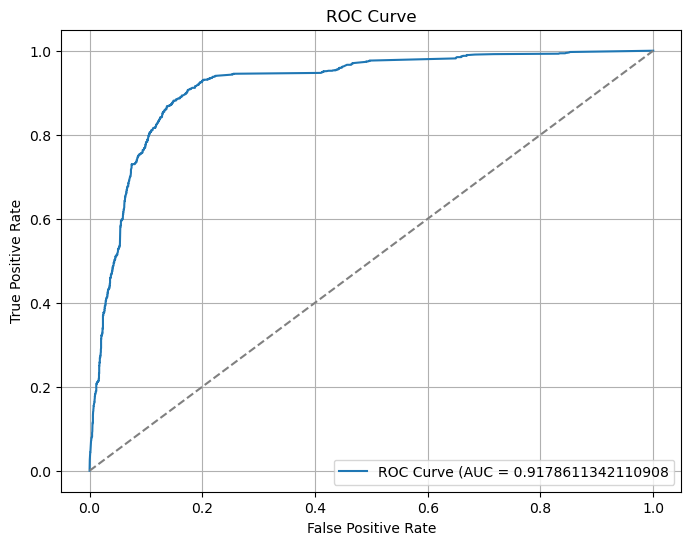

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

score = roc_auc_score(train["active"], oof_pred)
print(score)

# ROC 曲線のプロット
fpr, tpr, thresholds = roc_curve(train["active"], oof_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {score}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # ランダムな分類器の基準線
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

## 特徴量の重要性評価

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

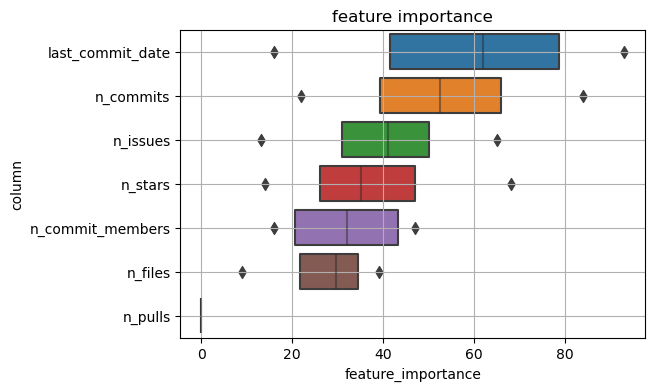

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# よくわからん…。けどまぁグラフの意味だけわかればいいか

def plot_importance(models: list):
    feature_importance = pd.DataFrame()
    
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = model.feature_name()
        _df['fold'] = i + 1
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)

    order = feature_importance.groupby('column').sum()[['feature_importance']].sort_values('feature_importance', ascending=False).index

    plt.figure(figsize=(6, 4))
    sns.boxenplot(data=feature_importance, x='feature_importance', y='column', order=order)
    plt.title('feature importance')
    plt.grid()
    plt.show()

plot_importance(models)

# 案外 star数 と file数 の比率は判定の上での参考にならなかったんだな

# plt.hist(oof_pred, bins=50)
# plt.show()

## 実際のテストデータの予測

In [11]:
import datetime

sample_sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
pred = np.zeros(sample_sub.shape[0]) # sample_sub.shape[0] はつまり縦の長さ（= 1814）

for model in models:
    pred += model.predict(test[use_cols])

pred /= len(models) # すべての要素を一気に 4 で割って平均値を得て、
sample_sub["pred"] = pred # それをサンプル提出データの "pred" 行に突っ込む
sample_sub.to_csv(f"output/{datetime.datetime.now()}.csv", index=False)